In [ ]:
import math
import numpy as np

rows = 8
cols = 8
edge = cols // 4

iter_num = 100

tau = 1 / 64
alpha0 = 0.1
alpha1 = 0.05
sigma = 0.125

clean = np.zeros((rows, cols))

for i in range(cols):
    clean[:, i] = i / (cols - 1)

for i in range(edge, cols - edge):
    clean[edge:rows - edge, i] = 1 - ((i - edge) / (cols - edge * 2 - 1))

noisy = clean + np.random.normal(0, 0.05, size=(rows, cols))


In [2]:
def square_sym_grad(src):
    rows = src.shape[0]
    cols = src.shape[1]
    
    src_zero = np.zeros((rows + 2, cols + 2))
    src_zero[1:-1, 1:-1] = src

    src_edge = np.zeros((src.shape[0] + 2, src.shape[1] + 2))
    src_edge[1:-1, 1:-1] = src
    src_edge[1:-1, 0] = src[:, 0]
    src_edge[1:-1, -1] = src[:, -1]
    src_edge[0, 1:-1] = src[0, :]
    src_edge[-1, 1:-1] = src[-1, :]
    
    dst = np.zeros((rows, cols, 3))

    for y in range(0, rows):
        for x in range(0, cols):
            dst[y, x, 0] = np.sum(np.array(([1, -2, 1])) * src_edge[y + 1, x:x + 3])
            dst[y, x, 1] = np.sum(np.array(([1, -2, 1])) * src_edge[y:y+3, x + 1])
            dst[y, x, 2] = (np.sum(np.array(([[0, 1, -1], [1, -2, 1], [-1, 1, 0]])) * src_zero[y:y + 3, x:x + 3])) * 0.5
    return dst


def square_div(src):
    rows = src.shape[0]
    cols = src.shape[1]
    
    src0 = np.zeros((rows + 2, cols + 2))
    src1 = np.zeros((rows + 2, cols + 2))
    src2 = np.zeros((rows + 2, cols + 2))

    src0[1:-1, 1:-1] = src[:, :, 0]
    src1[1:-1, 1:-1] = src[:, :, 1]
    src2[1:-1, 1:-1] = src[:, :, 2]

    src0[1:-1, 0] = src[:, 0, 0]
    src0[1:-1, -1] = src[:, -1, 0]
    src0[0, 1:-1] = src[0, :, 0]
    src0[-1, 1:-1] = src[-1, :, 0]
    
    src1[1:-1, 0] = src[:, 0, 1]
    src1[1:-1, -1] = src[:, -1, 1]
    src1[0, 1:-1] = src[0, :, 1]
    src1[-1, 1:-1] = src[-1, :, 1]

    dst = np.zeros((rows, cols))
    
    for y in range(0, rows):
        for x in range(0, cols):
            dst[y, x] = np.sum(np.array(([1, -2, 1])) * src0[y + 1, x:x + 3]) \
                + np.sum(np.array(([1, -2, 1])) * src1[y:y+3, x + 1]) \
                + np.sum(np.array(([[0, 1, -1], [1, -2, 1], [-1, 1, 0]])) * src2[y:y + 3, x:x + 3])
    return dst



In [94]:
def sym_grad(src):
    rows = src.shape[0]
    cols = src.shape[1]

    dst = np.zeros((rows, cols, 3))

    dst[:, 1:, 0] = src[:, 1:, 0] - src[:, :-1, 0]
    dst[:, 0, 0] = src[:, 0, 0]
    dst[:, -1, 0] = -src[:, -2, 0]
    
    dst[1:, :, 1] = src[1:, :, 1] - src[:-1, :, 1]
    dst[0, :, 1] = src[0, :, 1]
    dst[-1, :, 1] = -src[-2, :, 1]

    tmp = np.zeros((rows, cols, 2))
    tmp[:, 1:, 0] = src[:, 1:, 1] - src[:, :-1, 1]
    tmp[:, 0, 0] = src[:, 0, 1]
    tmp[:, -1, 0] = -src[:, -2, 1]
    
    tmp[1:, :, 1] = src[1:, :, 0] - src[:-1, :, 0]
    tmp[0, :, 1] = src[0, :, 0]
    tmp[-1, :, 1] = -src[-2, :, 0]

    dst[:, :, 2] = (tmp[:, :, 0] + tmp[:, :, 1]) * 0.5

    return dst


def divergence(src):
    rows = src.shape[0]
    cols = src.shape[1]
    
    dst = np.zeros((rows, cols, 2))
    
    tmp = np.zeros((rows, cols, 4))
    tmp[:, :-1, 0] = src[:, 1:, 0] - src[:, :-1, 0]
    tmp[:-1, :, 1] = src[1:, :, 1] - src[:-1, :, 1]
    tmp[:-1, :, 2] = src[1:, :, 2] - src[:-1, :, 2]
    tmp[:, :-1, 3] = src[:, 1:, 2] - src[:, :-1, 2]

    dst[:, :, 0] = tmp[:, :, 0] + tmp[:, :, 2]
    dst[:, :, 1] = tmp[:, :, 1] + tmp[:, :, 3]

    return dst


In [95]:
def update_nesterov_param(t):
    return (1 + math.sqrt(1 + 4 * t * t)) / 2

def shrink(image, lamb):
    abs_img = np.abs(image)
    shrink_img = np.where((abs_img - lamb) > 0,  (abs_img - lamb) * image / abs_img, 0)
    return shrink_img

    
def prox_grad(v_hat, alpha0, alpha1, sigma, iter_num = 100):
    t0 = 1
    t1 = update_nesterov_param(t0)
    t2 = update_nesterov_param(t1)

    eta0 = np.zeros((v_hat.shape[0], v_hat.shape[1], 2))
    eta_bar = np.zeros((v_hat.shape[0], v_hat.shape[1], 2))

    for i in range(iter_num):
        tmp = v_hat + sym_grad(eta_bar)
        q = shrink(tmp, alpha0)
    
        eta1 = shrink(eta_bar + sigma * divergence(tmp - q), sigma * alpha1)
        eta_bar = eta1 + t0 / t2 * (eta1 - eta0)

        eta0 = eta1
        t0 = t1
        t1 = t2
        t2 = update_nesterov_param(t2)

    print(np.sqrt(np.sum(np.square(v_hat - q + sym_grad(eta1)))))
    return v_hat - q + sym_grad(eta1)

In [ ]:

v0 = np.zeros((rows, cols, 3))
v_bar = np.zeros((rows, cols, 3))

t0 = 1
t1 = update_nesterov_param(t0)
t2 = update_nesterov_param(t1)

for i in range(iter_num):
# for i in range(1):
    # print(i)
    v1 = prox_grad(v_bar + tau * square_sym_grad(noisy - square_div(v_bar)), alpha0, alpha1, sigma, iter_num)
    v_bar = v1 + t0 / t2 * (v1 - v0)
    t0 = t1
    t1 = t2
    t2 = update_nesterov_param(t2)
    #print(np.sum(np.abs(square_div(v1))) / (rows * cols))

# calc_u
denoise = noisy - square_div(v1)

# print(input)
# print(denoise)


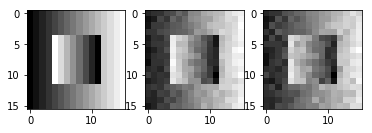

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(131)
ax.imshow(clean, cmap='gray')

ax = fig.add_subplot(132)
ax.imshow(noisy, cmap='gray')

ax = fig.add_subplot(133)
ax.imshow(denoise, cmap='gray')

plt.savefig("./image/test.png")